<a href="https://colab.research.google.com/github/ikram-hamizi/AML-DS-2021/blob/main/HMM_Viterbi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Hidden Markov Models and Deep Learning for POS Tagging**

- HMM: Viterbi Algorithm
- Deep Learning (with convolutions)
- Deep Learning (Recurrent NN)

Task Link: [click](https://hackmd.io/@gFZmdMTOQxGFHEFqqU8pMQ/SyYIjrBU_#Hidden-Markov-Models-for-POS-Tagging)

In [ ]:
!pip install wget

In [ ]:
# Make Resutls Reproducible

import numpy as np

SEED = 42
np.random.seed(SEED)

import os
os.environ['PYTHONHASHSEED']=str(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

### Load the Data + Visualization

In [ ]:
from time import time
import pandas as pd
import wget

wget.download('https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/train_pos.txt')
wget.download('https://raw.githubusercontent.com/Gci04/AML-DS-2021/main/data/PosTagging/test_pos.txt')

names = ['Word', 'Tag']
train = pd.read_csv("train_pos.txt", sep=" ", names=names) #a modified conll2000 dataset
test = pd.read_csv("test_pos.txt", sep=" ", names=names)

train = train.astype(str)
test = test.astype(str)

train.shape, test.shape

((220663, 2), (49389, 2))

In [ ]:
train.head(5)

,Word,Tag
0,Confidence,NN
1,in,IN
2,the,DT
3,pound,NN
4,is,VBZ


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_y_enc = label_encoder.fit_transform(train['Tag'])

tags_index = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))) #INDEX {tag:int} #starts from 1
tags_index_size = len(tags_index) 
"Number of unique tags:", tags_index_size

('Number of unique tags:', 45)

In [ ]:
# sanity check: are they the same order? -> yes
print(label_encoder.classes_)
print(np.array(list(tags_index.keys())))

['#' '$' "''" '(' ')' ',' '.' ':' 'CC' 'CD' 'DT' 'EX' 'FW' 'IN' 'JJ' 'JJR'
 'JJS' 'MD' 'NN' 'NNP' 'NNPS' 'NNS' 'PDT' 'POS' 'PRP' 'PRP$' 'RB' 'RBR'
 'RBS' 'RP' 'SYM' 'TO' 'UH' 'VB' 'VBD' 'VBG' 'VBN' 'VBP' 'VBZ' 'WDT' 'WP'
 'WP$' 'WRB' '``' 'nan']
['#' '$' "''" '(' ')' ',' '.' ':' 'CC' 'CD' 'DT' 'EX' 'FW' 'IN' 'JJ' 'JJR'
 'JJS' 'MD' 'NN' 'NNP' 'NNPS' 'NNS' 'PDT' 'POS' 'PRP' 'PRP$' 'RB' 'RBR'
 'RBS' 'RP' 'SYM' 'TO' 'UH' 'VB' 'VBD' 'VBG' 'VBN' 'VBP' 'VBZ' 'WDT' 'WP'
 'WP$' 'WRB' '``' 'nan']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


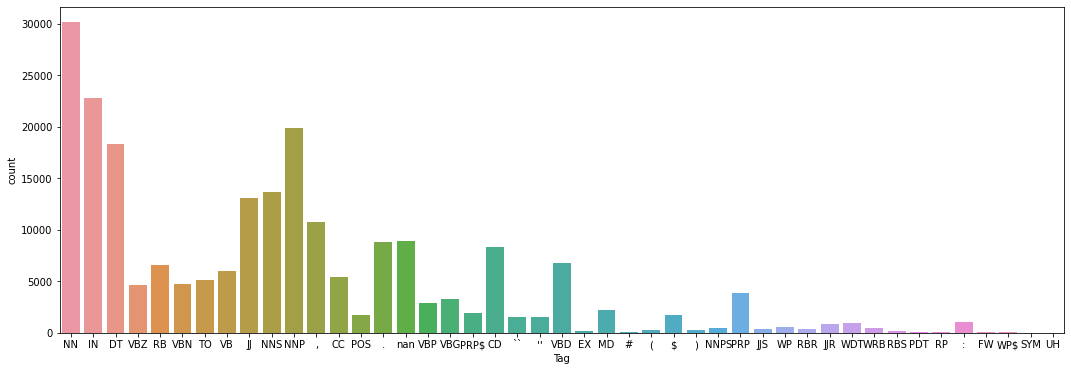

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(18,6))
sns.countplot(train['Tag'])

In [ ]:
import csv
from keras.utils import np_utils 

def sentence_tags_to_vector(sentence_tags, tags_index):
  vector = []
  for tag in sentence_tags:
    if tag in tags_index:
      vector.append(tags_index[tag])
    else:
      vector.append(-999)
  return vector

#Function: transforms dataset to a table of sentences and their corresebonding sequences of tags
def transform_to_sentence_tags_table(file_path, numerical_labels=False, ohe_labels=False, sen_maxlen=100):

  sentences_list = []
  tags_list = []

  sentence = []
  sentence_tags = []

  i=0
  with open(file_path, "r") as file:
    csv_reader = csv.reader(file, delimiter=' ')

    for line in csv_reader:
      i+=1  
      if len(line[0])==0 or line[0]==" ":
        
        if i>1:
          #Create sentence
          sentences_list.append(sentence)

          #Create list of tags

          if ohe_labels or numerical_labels:
            numerical_vector = sentence_tags_to_vector(sentence_tags, tags_index)
            if ohe_labels:
              padded_vector = pad_sequences([numerical_vector], padding='post', maxlen=sen_maxlen)
              ohe_matrix = np_utils.to_categorical(padded_vector, num_classes=len(tags_index), dtype=np.float64)
              tags_list.append(ohe_matrix)
            elif numerical_labels:
              padded_vector = pad_sequences([numerical_vector], padding='post', maxlen=len(tags_index))
              tags_list.append(padded_vector)
          elif not ohe_labels and not numerical_labels:
            tags_list.append(sentence_tags)

        #Reset
        sentence = []
        sentence_tags = []

      else:
        sentence.append(line[0])
        sentence_tags.append(line[1])

  df_sentences = pd.DataFrame(list(zip(sentences_list, tags_list)), columns=['Sentence', 'Tag'])
  return df_sentences

train_sentences = transform_to_sentence_tags_table('train_pos.txt')
test_sentences = transform_to_sentence_tags_table('test_pos.txt')

In [ ]:
print("Number of sentences:", train_sentences.shape) #number of sentences

Number of sentences: (8936, 2)


In [ ]:
train_sentences.head(6)

,Sentence,Tag
0,"[Confidence, in, the, pound, is, widely, expec...","[NN, IN, DT, NN, VBZ, RB, VBN, TO, VB, DT, JJ,..."
1,"[Chancellor, of, the, Exchequer, Nigel, Lawson...","[NNP, IN, DT, NNP, NNP, NNP, POS, VBN, NN, TO,..."
2,"[But, analysts, reckon, underlying, support, f...","[CC, NNS, VBP, VBG, NN, IN, NN, VBZ, VBN, VBN,..."
3,"[This, has, increased, the, risk, of, the, gov...","[DT, VBZ, VBN, DT, NN, IN, DT, NN, VBG, VBN, T..."
4,"[``, The, risks, for, sterling, of, a, bad, tr...","[``, DT, NNS, IN, NN, IN, DT, JJ, NN, NN, VBP,..."
5,"[``, If, there, is, another, bad, trade, numbe...","[``, IN, EX, VBZ, DT, JJ, NN, NN, ,, EX, MD, V..."


In [ ]:
# 0. split to x and y
train_x = train['Word']
train_y = train['Tag'].to_numpy()

test_x = test['Word']
test_y = test['Tag'].to_numpy()

In [ ]:
unique_tags = train['Tag'].unique()
unique_words = train['Word'].unique()

# numeric variables
total_words = len(unique_words)
total_tags = len(unique_tags) #len(unique_tags)

### **Task 1**: Calculate the transition probability and emission matrices 
This is the First step towards viterbi.

In [ ]:
from collections import Counter

agg_dict = {'Tag':Counter}
train_agg = train.groupby(by=['Word'], as_index=False).agg(agg_dict)

In [ ]:
from tqdm import tqdm 

"""1. Func: get prior probabilities"""
def get_priors():
  priors = np.empty(total_tags) #vector

  counts = train['Tag'].value_counts()
  total = sum(counts) # = 220663 = len(train)

  priors = counts/total
  return priors


"""2. Func: get EMISSIONS probabilities matrix"""

#helper function
def get_emission_proba_vector(word):
  #1. GET COUNTS
  tags_counts = dict.fromkeys(unique_tags.tolist(),1e-8) #initialize dict with keys (unique tags)
  word_sample_space_count = 0

  #Join the two columns by word. The tag column becomes a counter of tags 
  tag_counter_of_word = list(train_agg[train_agg['Word']==word].to_numpy()[0][1].items())
  for tag_counter in tag_counter_of_word:
    tags_counts[tag_counter[0]] += tag_counter[1]
    word_sample_space_count += tag_counter[1]

  #2. GET PROBAS
  word_probs_vector = list(tags_counts.values())
  if word_sample_space_count is not 0:
    word_probs_vector = [w/word_sample_space_count for w in word_probs_vector]

  return word_probs_vector

#EMISSIONS
def get_emissions_matrix():
  emissions = np.empty((total_words, total_tags)) #matrix'

  with tqdm(total=total_words) as pbar:
    for i, word in enumerate(unique_words):
      emissions[i] = get_emission_proba_vector(word) # P(ti|tj)
      pbar.update()

  return emissions



"""3. Func: get transition probabilities matrix"""

#helper function
def get_trans_proba_vector(tag):

  tags_counts = dict.fromkeys(unique_tags.tolist(),1e-8) #initialize dict with keys (unique tags)
  tags_rows = train_sentences['Tag']

  #1. GET COUNTS
  for list_of_tags in tags_rows: #for each list of tags in a row

    if tag not in list_of_tags: continue;  
    else: i = list_of_tags.index(tag) #index of our tag
    
    for iter in range(len(list_of_tags)):#for each tag present in the row
      if i+1>=len(list_of_tags): break;

      next_tag = list_of_tags[i+1:][0] #get the tag that appears after our desired tag
      if 0>=i+1>=len(list_of_tags): break

      if (list_of_tags[i]==tag): #if the previous tag (i) is our tag, increment the count of our current one
        tags_counts[next_tag]+=1

      if tag not in list_of_tags[i+1:]: break;
      else: i += list_of_tags[i+1:].index(tag)+1; 

  tags_probs_vector = list(tags_counts.values())
  
  #2. GET PROBAS
  tag_sample_space_count =  sum(tags_probs_vector)
  tags_probs_vector = [t/tag_sample_space_count for t in tags_probs_vector] if tag_sample_space_count is not 0 else tags_probs_vector

  return tags_probs_vector

#TRANSITION
def get_transitions_matrix():
  transitions = np.zeros((total_tags, total_tags), dtype='float32') #matrix

  with tqdm(total=total_tags) as pbar:
    for i, tag in enumerate(unique_tags):
        transitions[i] = get_trans_proba_vector(tag) # P(ti|tj)
        pbar.update()

  return transitions

In [ ]:
#1. Prior Probabilities Pi: P(ti)
priors = get_priors() #vector

#2. Emission Probabilities: P(wi|ti)
emissions = get_emissions_matrix() #matrix

#3. Transision Probabilities: P(ti|ti-1)
transitions = get_transitions_matrix() #matrix

100%|██████████| 45/45 [00:00<00:00, 67.20it/s]


In [ ]:
#convert the two matrices to dataframes
emissions_df = pd.DataFrame(emissions, columns=unique_tags, index=unique_words)
transitions_df = pd.DataFrame(transitions, columns=unique_tags, index=unique_tags)
transitions_df.head()

,NN,IN,DT,VBZ,RB,VBN,TO,VB,JJ,NNS,NNP,",",CC,POS,.,nan,VBP,VBG,PRP$,CD,``,'',VBD,EX,MD,#,(,$,),NNPS,PRP,JJS,WP,RBR,JJR,WDT,WRB,RBS,PDT,RP,:,FW,WP$,SYM,UH
NN,0.117678,0.247835,0.007699,0.038795,0.017058,0.012080,0.041483,0.001427,0.009956,0.084990,0.009724,0.112534,0.039724,2.203564e-02,0.105731,3.318621e-13,0.003650,0.007898,0.000166,0.005343,0.002190,5.210235e-03,0.048651,3.318621e-04,0.018186,3.318621e-05,0.001792,0.000498,2.024359e-03,2.986759e-04,0.005277,3.318621e-13,0.002456,0.003850,0.001327,0.007865,1.991173e-03,0.000199,3.318621e-05,6.637241e-05,0.011482,1.659310e-04,1.991172e-04,6.637241e-05,3.318621e-13
IN,0.111560,0.029746,0.326245,0.001318,0.014983,0.005844,0.003427,0.000439,0.084186,0.061470,0.136737,0.004482,0.001801,4.393866e-13,0.000791,4.393866e-13,0.000352,0.027725,0.036689,0.062129,0.006064,5.272640e-04,0.000176,1.449976e-03,0.000176,7.030186e-04,0.000439,0.027857,4.393866e-05,1.889362e-03,0.030801,3.031768e-03,0.002417,0.000483,0.005361,0.003251,1.713608e-03,0.001801,1.230282e-03,4.393866e-13,0.000439,2.196933e-04,4.393866e-13,4.393866e-13,4.393866e-13
DT,0.484591,0.008237,0.001309,0.008891,0.010909,0.015600,0.000273,0.000764,0.198931,0.073201,0.111002,0.002345,0.001036,5.454644e-13,0.001745,5.454644e-13,0.000927,0.010091,0.000436,0.025746,0.004909,5.454644e-13,0.003218,5.454644e-13,0.001745,3.272787e-04,0.000436,0.008455,1.090929e-04,2.127311e-03,0.000764,9.327442e-03,0.000655,0.001364,0.006382,0.000218,5.454644e-13,0.003055,5.454644e-13,5.454644e-13,0.000491,1.636393e-04,5.454644e-13,5.454644e-13,2.181858e-04
VBZ,0.039595,0.095976,0.168496,0.001506,0.134495,0.144609,0.045406,0.002582,0.075963,0.017215,0.061760,0.027975,0.003658,2.151926e-12,0.029051,2.151926e-12,0.001291,0.051216,0.010114,0.017861,0.008393,2.151926e-12,0.003443,8.607704e-04,0.001722,2.151926e-12,0.000215,0.004519,2.151926e-12,2.151926e-12,0.022380,4.303852e-04,0.002582,0.002152,0.007962,0.000646,7.746933e-03,0.001506,2.151926e-04,1.506348e-03,0.004949,2.151926e-12,2.151926e-12,2.151926e-12,2.151926e-12
RB,0.008023,0.129276,0.050711,0.041023,0.058886,0.086285,0.025431,0.109749,0.102785,0.004995,0.006812,0.093249,0.007115,4.541326e-04,0.062519,1.513775e-12,0.031184,0.030730,0.002725,0.022858,0.001060,1.059643e-03,0.050560,6.055101e-04,0.011505,3.027551e-04,0.000151,0.015289,1.513775e-04,3.027551e-04,0.011202,6.055101e-04,0.001665,0.004693,0.017408,0.000454,3.481683e-03,0.000303,4.541326e-04,1.513775e-12,0.003784,1.513775e-04,1.513775e-12,1.513775e-12,1.513775e-12


In [ ]:
emissions_df.head()

,NN,IN,DT,VBZ,RB,VBN,TO,VB,JJ,NNS,NNP,",",CC,POS,.,nan,VBP,VBG,PRP$,CD,``,'',VBD,EX,MD,#,(,$,),NNPS,PRP,JJS,WP,RBR,JJR,WDT,WRB,RBS,PDT,RP,:,FW,WP$,SYM,UH
Confidence,1.000000e+00,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08,1.000000e-08
in,4.414361e-03,9.935256e-01,2.942908e-12,2.942908e-12,2.060035e-03,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12,2.942908e-12
the,1.084716e-12,1.844018e-03,9.981560e-01,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12,1.084716e-12
pound,1.000000e+00,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10,7.142857e-10
is,7.067138e-12,7.067138e-12,7.067138e-12,9.978799e-01,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,2.120141e-03,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12,7.067138e-12


### **Task 2**: Implement Viterbi Algorithm for POS-Tagging

In [ ]:
import numpy as np

def viterbi(sentence, emissions_df, transitions_df, priors):
  
  number_of_words = len(sentence)
  total_tags = len(transitions)
  
  highest_prob_so_far = 1

  best_states_vector = np.zeros(number_of_words, dtype=object) #states are strings (tags)
  viterbi_matrix = np.zeros((total_tags, number_of_words))

  for i, word in enumerate(sentence):
    # multiply: highest_prob_so_far*p(wi|tags)*p(previous_tag); i.e.
    # multiply: highest_prob_so_far_value * emissions(word)_vector * transitions(previous_tag)_vector
    
    if word not in emissions_df.index:
      word = 'nan'

    emissions_word = emissions_df.loc[word,:].to_numpy()
    
    if i==0: #initialize: use priors instead of highest_prob_so_far
      viterbi_matrix[:,i] = np.log10(priors) + np.log10(emissions_word)
    else:
      transitions_tag = transitions_df.loc[best_states_vector[i-1],:].to_numpy()
      viterbi_matrix[:,i] = np.log10(highest_prob_so_far)+np.log10(emissions_word)+np.log10(transitions_tag)
      
    highest_prob_so_far = pow(10, max(viterbi_matrix[:,i]))
    highest_prob_so_far_index = np.argmax(viterbi_matrix[:,i]) #index = tag_number_representation
    best_states_vector[i] = unique_tags[highest_prob_so_far_index] 

  return best_states_vector #most likely path

In [ ]:
def viterbi_predict(test_x):
  pred_y = []

  with tqdm(total=len(test_x)) as pbar:
    for sentence in test_x:
      pred_y.append(viterbi(sentence, emissions_df, transitions_df, priors))
      pbar.update()

  return pred_y

In [ ]:
def accuracy(y_test, y_pred):
  avg_accuracy = 0
  for test_instance, pred_instance in list(zip(y_test, y_pred)):
    correct = [y1 for y1, y2 in list(zip(test_instance, pred_instance)) if y1 == y2] 
    avg_accuracy += len(correct)/float(len(test_instance))/float(len(y_test))
    
  return avg_accuracy

In [ ]:
test_x_viterbi = test_sentences['Sentence'].to_numpy()
test_y_viterbi = test_sentences['Tag'].to_numpy()

start_viterbi = time()
pred_y_viterbi = viterbi_predict(test_x_viterbi)
end_viterbi = time()
total_viterbi = end_viterbi - start_viterbi

print(f"\n1. Viterbi Accuracy = {accuracy(test_y_viterbi, pred_y_viterbi)}%")
print(f"Time to finish: {total_viterbi} seconds")

100%|██████████| 2012/2012 [00:15<00:00, 127.96it/s]


1. Viterbi Accuracy = 0.8994715519094878%
Time to finish: 15.727505683898926 seconds


### **Task 3**: Implement RNN for POS-Tagging

#### **1. Convert all words to numerical vector representation**
1. Convert each **word to an integer** (index). Start from 1. Reserve 2 for `PAD` and `UNK`.
2. Create a **matrix of sentences** where each cell is an integer representings word. Each sentence is of legnth 100 (100 words). Pad the sentences. This matrix can be fed to the embedding layer.
3. Set the **embedding layer** where the rows indices correspond to the word integers.

***Note***: *in the dataset, the maximum sentence length is 73, and the maximum word length is 43.*


In [ ]:
'''1. VOCAB INDEX: Convert each **word to an integer** (index). Start from 1. Reserve 2 for PAD and UNK.'''
unique_words = train['Word'].unique()
unique_words_lower = np.unique((np.array([w.lower() for w in unique_words])))
vocab = dict(zip(unique_words_lower, range(1,len(unique_words_lower)+1))) #INDEX {character:int} #starts from 1
vocab_size = len(vocab) # = 17259 (when it is not lowered, it is 19123 == len(unique_words))

In [ ]:
# GLOBAL VARIABLES
#a. Find the maximum length of a sentence
sen = train_sentences['Sentence'].to_numpy()
sen_maxlen = len(max(sen, key=len)) # = 78
wor = train['Word'].to_numpy()

#b. Set the global variables
batch_size = 32
total_vocab = len(vocab) + 2 #17261
sen_maxlen = sen_maxlen + (100-sen_maxlen) # make it = 100
word_maxlen = len(max(wor, key=len)) # = 43

total_sentences_train = len(train_sentences)
total_sentences_test = len(test_sentences)

In [ ]:
'''2. Create a **matrix of sentences** where each cell is an integer representings word.
      Each sentence is of legnth 100 (100 words).
      Pad the sentences.
      This matrix can be fed to the embedding layer.'''

from keras.preprocessing.sequence import pad_sequences

# Convert the a sentence to an array of numbers. Add post-padding.
def sentence_to_vector(sentence):
  vector = []
  for word in sentence:
    word = word.lower()
    if word in vocab:
      integer_representation = vocab[word]
      vector.append(integer_representation)
      if len(vector) >= sen_maxlen:
        break
  vector = pad_sequences([vector], padding='post', maxlen=sen_maxlen)
  return vector

matrix_train_x = np.zeros((total_sentences_train, sen_maxlen))  
for i, sentence in enumerate(train_sentences):
  matrix_train_x[i] = sentence_to_vector(sentence)

matrix_test_x = np.zeros((total_sentences_test, sen_maxlen))  
for i, sentence in enumerate(test_sentences):
  matrix_test_x[i] = sentence_to_vector(sentence)

In [ ]:
'''3. Set the **embedding layer** where the rows indices correspond to the word integers.'''
#1. Download GloVe embeddings

import zipfile

wget.download("http://nlp.stanford.edu/data/glove.6B.zip")
with zipfile.ZipFile("glove.6B.zip", 'r') as f:
  f.extractall("")

In [ ]:
#2. Choose embeddings of maxlen (size 100)
path_to_glove_file = "glove.6B.100d.txt"

#3. Keep minimum and maximum values in word embeddings to add
min_emb_value = -1e-8
max_emb_value = 1e-8

#3. Make a dict mapping GloVe chars to their NumPy vector representation
embedding_vectors = {}
with open(path_to_glove_file, 'r', encoding="utf8") as f:
    for line in f:
        line_array = line.strip().split(" ")
        word = line_array[0]
        vector = np.array(line_array[1:], dtype=float)
        min_emb_value = np.min(vector) if np.min(vector)<min_emb_value else min_emb_value
        max_emb_value = np.max(vector) if np.max(vector)>max_emb_value else max_emb_value
        embedding_vectors[word] = vector

print(f"Found {len(embedding_vectors)} wrod vectors.")

embedding_dim = list(embedding_vectors.values())[0].shape[0]
print("Embedding Vector size =", embedding_dim)

Found 400000 wrod vectors.
Embedding Vector size = 100


In [ ]:
"min", min_emb_value, "max", max_emb_value

('min', -4.0666, 'max', 3.575)

In [ ]:
#4. Prepare a matrix to be used in the model (embedding of words)
misses = 0
hits = 0
missed_words = []

word_embedding_matrix_train_x = np.random.uniform(-0.5, 0.5, size=(total_vocab, embedding_dim))  
for word, value in vocab.items():
  embedding_vector = embedding_vectors.get(word)
  if embedding_vector is not None:
    word_embedding_matrix_train_x[value] = embedding_vector
    hits+=1
  else:
    missed_words.append(word)
    misses+=1

print("Converted %d words (%d misses)" % (hits, misses))
word_embedding_matrix_train_x.shape #added 2 for unknown

Converted 15795 words (1464 misses)


(17261, 100)

In [ ]:
#Example of a miss
print(missed_words[936])
word_embedding_matrix_train_x[vocab[missed_words[936]]]

left-stream


array([ 0.4351392 ,  0.41581059,  0.01334232, -0.11016987, -0.18609691,
       -0.11914627, -0.04556634,  0.42029121,  0.333771  ,  0.48621899,
       -0.12375477,  0.03143299, -0.47657092,  0.35239814,  0.03034039,
        0.20047681,  0.04325829,  0.26232434, -0.48934633, -0.01623641,
        0.31930768, -0.17249322, -0.0482819 , -0.40368594,  0.3063288 ,
        0.24489311,  0.18694933,  0.27813586,  0.08740598,  0.21758698,
        0.28123855,  0.07683449,  0.42730906,  0.32872708,  0.44066565,
        0.08867938,  0.23198397, -0.45302301, -0.34930728, -0.47421331,
        0.04036456,  0.44240125, -0.06515136, -0.09763807, -0.1736167 ,
       -0.32402334, -0.46717193, -0.19608272,  0.23643656, -0.09039739,
       -0.33710965, -0.32068986, -0.347174  ,  0.29244347, -0.29411762,
        0.03885047,  0.36426601, -0.32662653,  0.33233578, -0.31607586,
        0.39861772,  0.43046175,  0.27112082,  0.4780914 , -0.05850225,
        0.18698118, -0.10932055,  0.35855302, -0.22974836, -0.16

#### 2. **Convert Labels to numerical vectors (one-hot-encoding)**

In [ ]:
# Get y labels in one-hot-encodings
train_sentence_tags_NN = transform_to_sentence_tags_table('train_pos.txt', ohe_labels=True)['Tag']
test_sentence_tags_NN = transform_to_sentence_tags_table('test_pos.txt', ohe_labels=True)['Tag']

x_train = matrix_train_x
y_train = train_sentence_tags_NN

x_test = matrix_test_x
y_test = np.asarray(test_sentence_tags_NN)

print("A sentence's one-hot-encoded tags: ",y_train[0].shape)
print("Number of one hot encoded tags:", y_train[0][0].shape)
print(x_train.shape, y_train.shape) 


#y.shape should be (sample_size, sen_maxlen, total_tags) -> Using tf.convert_to_tensor gives an error (tf.decorator). Use solution for Error #2 instead.
#correct is: (sample_size=8936, sen_maxlen=100, total_tags=45)

#Error#1: ValueError: Failed to convert a NumPy array to a Tensor (Upported object type numpy.ndarray).nsu
#avoid by setting dtype('float64') for x and y

#Error#2: ValueError: setting an array element with a sequence.
#Comes when you do y_train.astype(np.float64). You have to iterate over each array and set its dtype to float.

y_train_tf = np.array([np.asarray(p, dtype=np.float64) for p in y_train]).squeeze(1) 
print(y_train_tf.shape)

A sentence's one-hot-encoded tags:  (1, 100, 45)
Number of one hot encoded tags: (100, 45)
(8936, 100) (8936,)
(8936, 100, 45)


In [ ]:
#Visualize
numeric_train = pd.DataFrame(list(zip(x_train,y_train)), columns=['sentences', 'tags'])
print(numeric_train['sentences'][0].shape, numeric_train['tags'][0].shape)
numeric_train.head()

(100,) (1, 100, 45)


,sentences,tags
0,"[13779.0, 3826.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,"[1975.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


#### **3. Build the model + train**

In [ ]:
from keras.layers import GlobalMaxPooling1D, Flatten, Reshape, GlobalMaxPooling2D, Conv2D, Embedding, Dense, Lambda, Dropout, BatchNormalization
from keras import Input, Model, Sequential

# Create, add Embedding layer and freeze it 
embedding_layer = Embedding(
    input_dim = total_vocab, #len(vocab)+2
    output_dim = 100, #embedding_dim
    # input_length=word_maxlen,
    weights = [word_embedding_matrix_train_x],
    trainable=True)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
early_stopping = EarlyStopping(monitor='val_loss',
                               patience = 5,
                               restore_best_weights=True
                               )
callbacks = [ReduceLROnPlateau(), early_stopping]

#### 3.1 **NN Model with Convolutional Layer**

In [ ]:
# Get y labels in one-hot-encodings
train_sentence_tags_NN = transform_to_sentence_tags_table('train_pos.txt', numerical_labels=True)['Tag']
test_sentence_tags_NN = transform_to_sentence_tags_table('test_pos.txt', numerical_labels=True)['Tag']

x_train_conv = matrix_train_x
y_train_conv = train_sentence_tags_NN

x_test_conv = matrix_test_x
y_test_conv = np.asarray(test_sentence_tags_NN)

print("A sentence's one-hot-encoded tags: ",y_train_conv[0].shape)
print("Number of one hot encoded tags:", y_train_conv[0][0].shape)
print(x_train_conv.shape, y_train_conv.shape) 


#y.shape should be (sample_size, sen_maxlen, total_tags) -> Using tf.convert_to_tensor gives an error (tf.decorator). Use solution for Error #2 instead.
#correct is: (sample_size=8936, sen_maxlen=100, total_tags=45)

#Error#1: ValueError: Failed to convert a NumPy array to a Tensor (Upported object type numpy.ndarray).nsu
#avoid by setting dtype('float64') for x and y

#Error#2: ValueError: setting an array element with a sequence.
#Comes when you do y_train.astype(np.float64). You have to iterate over each array and set its dtype to float.

y_train_conv_tf = np.array([np.asarray(p, dtype=np.float64) for p in y_train_conv]).squeeze(1) 
print(y_train_conv_tf.shape)

A sentence's one-hot-encoded tags:  (1, 45)
Number of one hot encoded tags: (45,)
(8936, 100) (8936,)
(8936, 45)


In [ ]:
'''Deep Learning w/ convolutional layer:
# #1. Input as a sentence
# #2. From sentence get embeddings with word embeddings 
# #3. Dimension of embedding matrix is 2D, so you can treat it as an image
# #   - You can put it to Conv2D + MaxPool (to flatten after embedding) [according to paper]
# #   - Or directly to FC 
'''
from keras.layers import InputLayer

batch_size = 64
# input = Input(shape=(sen_maxlen,)); print("input", input.shape)
# # input = InputLayer(input_shape=(sen_maxlen, ))
# z = embedding_layer(input); print("emd", z.shape)
# z = Reshape((sen_maxlen, embedding_dim, 1))(z); print('resh', z.shape)
# z = Conv2D(kernel_size=5, filters=100,  activation='relu')(z); print("conv", z.shape) # #filters = embedding_dim
# z = GlobalMaxPooling2D()(z)
# # z = BatchNormalization()(z)
# # z = Dropout(0.2)(z)
# # z = Flatten()(z)
# z = Dense(196, activation='relu')(z)
# z = BatchNormalization()(z)
# z = Dropout(0.2)(z)
# output = Dense(len(unique_tags),activation='softmax')(z)
# model = Model(input, output, name='conv-POS')

model = Sequential()
model.add(InputLayer(input_shape=(100, )))
model.add(embedding_layer)
model.add(Reshape((100, 100, 1)))
model.add(Conv2D(kernel_size=5, filters=100, activation='relu'))
model.add(GlobalMaxPooling2D())
model.add(Dense(320, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(unique_tags),activation='softmax'))

In [ ]:
# model.compile(optimizer=Adam(1e-2), loss='binary_crossentropy', metrics = ['accuracy'])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1726100   
_________________________________________________________________
reshape_10 (Reshape)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 96, 96, 100)       2600      
_________________________________________________________________
global_max_pooling2d_9 (Glob (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 320)               32320     
_________________________________________________________________
batch_normalization_9 (Batch (None, 320)               1280      
_________________________________________________________________
dropout_9 (Dropout)          (None, 320)             

In [2]:
model.fit(x_train_conv,y_train_conv_tf, batch_size=batch_size, epochs=20, validation_split=0.2, callbacks=callbacks, verbose=2)

#### 3.2 **RNN Model**

In [ ]:
#RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam
 
 
model = Sequential()
model.add(InputLayer(input_shape=(sen_maxlen, )))
model.add(embedding_layer)
model.add(Bidirectional(LSTM(80, return_sequences=True)))
model.add(Dense(len(tags_index), activation='softmax'))

# "If labels in one-hot representation, use CategoricalCrossentropy loss. " 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
 
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1726100   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 100, 160)          115840    
_________________________________________________________________
dense_12 (Dense)             (None, 100, 45)           7245      
Total params: 1,849,185
Trainable params: 1,849,185
Non-trainable params: 0
_________________________________________________________________


In [ ]:
x_train.dtype, y_train_tf.dtype '''must be float to be able to'''

(dtype('float64'), dtype('float64'))

In [ ]:
model.fit(x_train,y_train_tf, batch_size=64, epochs=50, validation_split=0.2, callbacks=callbacks, verbose=2)

###BROUILLONS
Ignorer

In [ ]:
'''BROUILLONS'''
# from sklearn.metrics import fbeta_score, label_ranking_average_precision_score
# from sklearn.preprocessing import MultiLabelBinarizer

# # accuracy_viterbi = fbeta_score(test_y_viterbi, pred_y_viterbi,beta=0.5,  average='samples')
# # accuracy_viterbi2 = label_ranking_average_precision_score(test_y_viterbi, pred_y_viterbi)

#I got this error because funcitonal API i named output x and my training set i named x. 
# Train_x was overritten by the NN output x. which made it of type 'tensorflow.python.keras.engine.keras_tensor.KerasTensor.
#Removing it resulted in x_train being a numpy.ndarray.
# ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'>]


# from tensorflow import convert_to_tensor
# y = pad_sequences([convert_to_tensor(x) for x in y])
# y.shape #45x45 encodings for each label. [0,0,0...] if label is not in sentence.

from sklearn.preprocessing import MultiLabelBinarizer
# mlb = MultiLabelBinarizer(classes=label_encoder.classes_)
# y = mlb.fit_transform(y)
# y, y.shape
